In [1]:
import ROOT
import uproot
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as colors
from matplotlib.lines import Line2D
import numpy as np
import array
from scipy.stats import norm
from scipy.optimize import curve_fit
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN
import matplotlib.transforms as mtransforms
from itertools import groupby
from operator import itemgetter
from scipy import stats

Welcome to JupyROOT 6.28/00


In [2]:
#Opening .root file and creating dataframes from it's TTrees
file = uproot.open("data/digi_00000154.root")
dataframes = {}

for key in file.keys():
    if isinstance(file[key], uproot.behaviors.TTree.TTree):
        tree = file[key]
        df = tree.arrays(library="pd")
        dataframes[key] = df.astype(int)

In [ ]:
df

In [3]:
#Delete unused columns and create df for work
dataframes['outputtree;1'].drop(["orbitNumber", "bunchCounter", "runParameter", "pulse_stretch", "slot", "OH", "CH", "digiDirection"], axis=1, inplace=True)
dataframes['outputtree;2'].drop(["orbitNumber", "bunchCounter", "runParameter", "pulse_stretch", "slot", "OH", "CH", "digiDirection"], axis=1, inplace=True)
df = dataframes['outputtree;2']
df = df.reset_index()
df.drop(["subentry", "eventCounter"], axis=1, inplace=True)

In [84]:
df[df['entry'] == 3]

,entry,VFAT,digiBX,digiChamber,digiEta,digiStrip
65,3,5,1,2,3,42
66,3,5,2,2,3,43
67,3,5,2,3,3,44
68,3,5,2,3,3,43
69,3,5,2,3,3,42
70,3,5,2,3,3,41
71,3,5,2,3,3,40
72,3,5,3,1,3,44
73,3,5,3,2,3,44
74,3,5,3,2,3,41


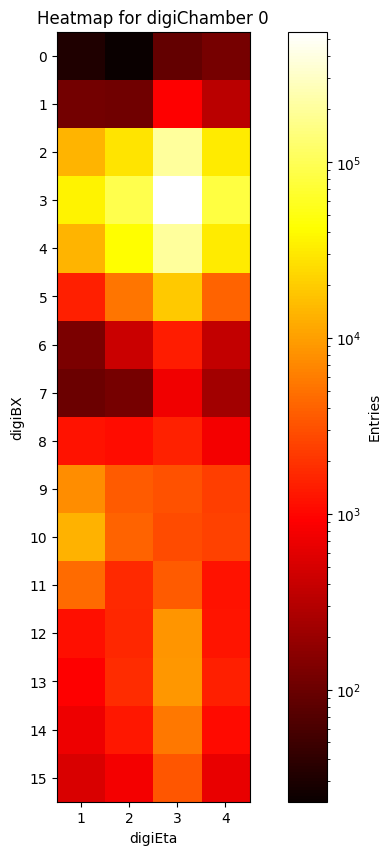

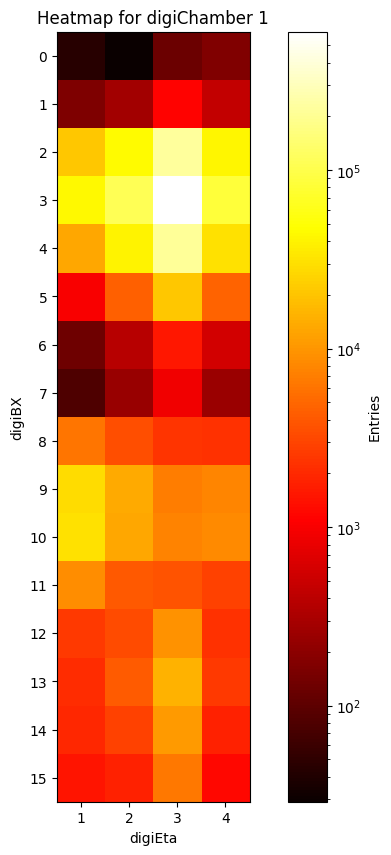

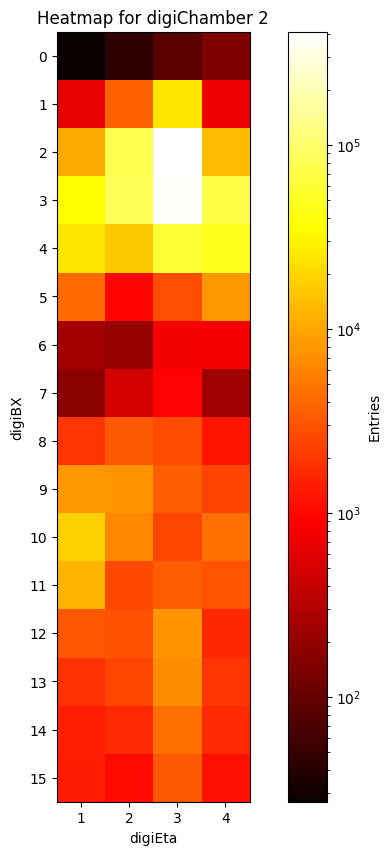

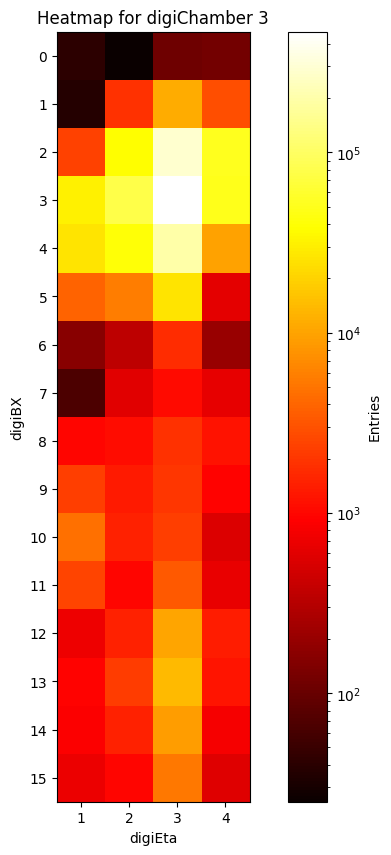

In [223]:
def plot_heat(df, digiChamber):
    # Filter dataframe by digiChamber
    df_chamber = df[df['digiChamber'] == digiChamber]
    
    # Get unique values for digiEta and digiBX
    unique_digiEta = sorted(list(df_chamber['digiEta'].unique()))
    unique_digiBX = sorted(list(df_chamber['digiBX'].unique()))

    # Create empty 2D array to hold counts
    counts = np.zeros((len(unique_digiBX), len(unique_digiEta)))

    # Fill counts array with number of entries for each digiEta and digiBX
    for idx_eta, digiEta in enumerate(unique_digiEta):
        for idx_bx, digiBX in enumerate(unique_digiBX):
            counts[idx_bx, idx_eta] = len(df_chamber[(df_chamber['digiEta'] == digiEta) & (df_chamber['digiBX'] == digiBX)])

    # Create heatmap
    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(counts, cmap='hot', norm=colors.LogNorm(vmin=counts.min()+1, vmax=counts.max()))

    # Set x and y labels
    ax.set_xticks(range(len(unique_digiEta)))
    ax.set_xticklabels(unique_digiEta)
    ax.set_yticks(range(len(unique_digiBX)))
    ax.set_yticklabels(unique_digiBX)

    # Add colorbar
    cbar = ax.figure.colorbar(im, ax=ax, label='Entries')
    plt.xlabel('digiEta')
    plt.ylabel('digiBX')


    # Set title
    ax.set_title(f'Heatmap for digiChamber {digiChamber}')

    # Show plot
    plt.show()
for i in range(0, 4):
    plot_heat(df, i)

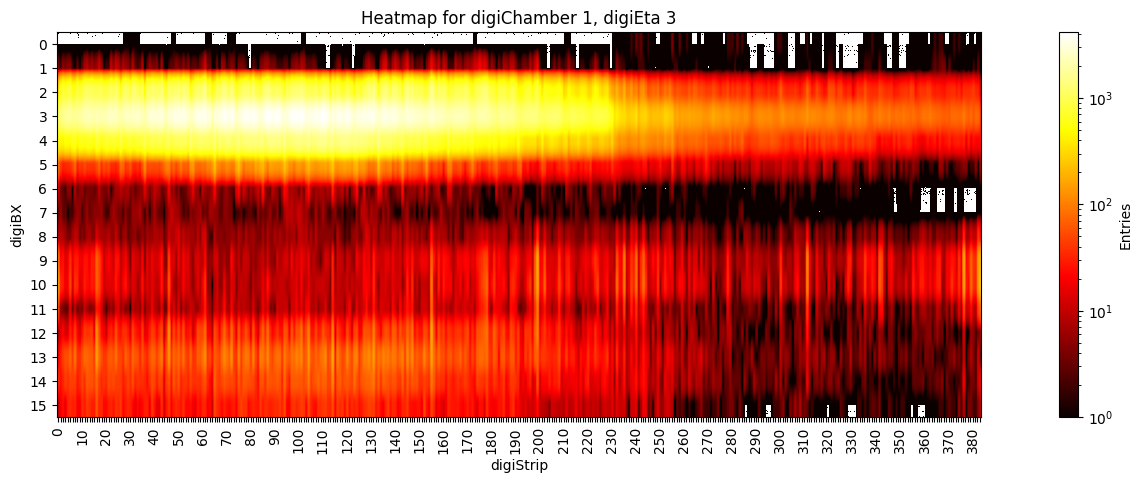

In [239]:
def plot_heat(df, digiChamber, digiEta):
    # Filter dataframe by digiChamber and digiEta
    df_filtered = df[(df['digiChamber'] == digiChamber) & (df['digiEta'] == digiEta)]
    
    # Get unique values for digiStrip and digiBX
    unique_digiStrip = sorted(list(df_filtered['digiStrip'].unique()))
    unique_digiBX = sorted(list(df_filtered['digiBX'].unique()))

    # Create empty 2D array to hold counts
    counts = np.zeros((len(unique_digiBX), len(unique_digiStrip)))

    # Fill counts array with number of entries for each digiStrip and digiBX
    for idx_strip, digiStrip in enumerate(unique_digiStrip):
        for idx_bx, digiBX in enumerate(unique_digiBX):
            counts[idx_bx, idx_strip] = len(df_filtered[(df_filtered['digiStrip'] == digiStrip) & (df_filtered['digiBX'] == digiBX)])

    # Create heatmap
    fig, ax = plt.subplots(figsize=(20, 5)) 
    im = ax.imshow(counts, cmap='hot', norm=colors.LogNorm(vmin=counts.min()+1, vmax=counts.max()), aspect=10)

    # Set x and y labels
    ax.set_xticks(range(len(unique_digiStrip)))
    ax.set_xticklabels(unique_digiStrip if len(unique_digiStrip) <= 20 else [s if i % 10 == 0 else '' for i, s in enumerate(unique_digiStrip)], rotation=90)  # Rotate labels and show only every 10th label if there are more than 20 labels
    ax.set_yticks(range(len(unique_digiBX)))
    ax.set_yticklabels(unique_digiBX)
    plt.xlabel('digiStrip')
    plt.ylabel('digiBX')

    # Add colorbar
    cbar = ax.figure.colorbar(im, ax=ax, label='Entries')

    # Set title
    ax.set_title(f'Heatmap for digiChamber {digiChamber}, digiEta {digiEta}')

    # Show plot
    plt.show()

plot_heat(df, 1, 3)

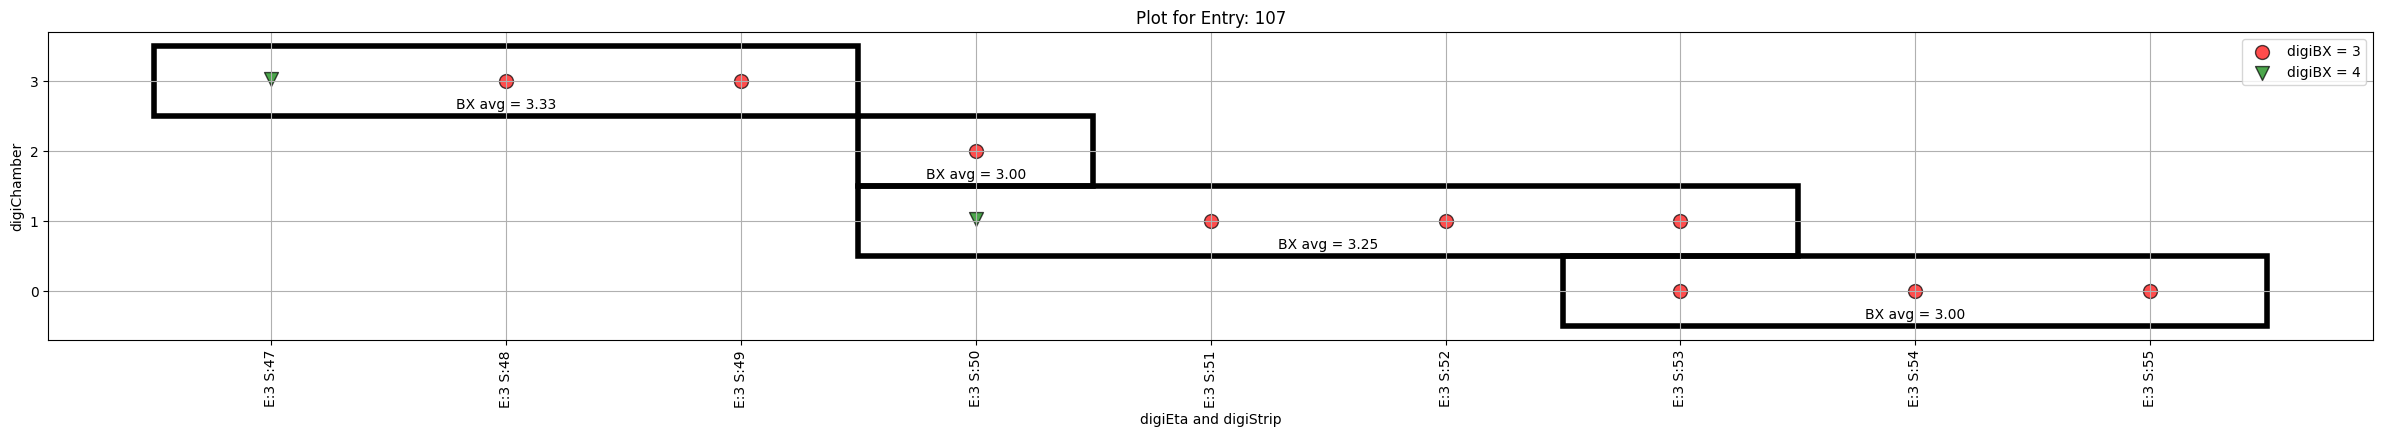

In [235]:
def plot_digi(df: pd.DataFrame, entry: int, bx_range: tuple = None) -> None:
    colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'orange', 'purple', 'pink', 'gray', 'cyan', 'lime', 'maroon', 'navy']
    markers = ['o', 'v', '^', '<', '>', 's', 'p', '*', 'h', 'D', '+', 'x', 'd', '|', '_']

    # Filter dataframe by entry and digiBX range
    if bx_range is None:
        df_entry = df[df['entry'] == entry]
    else:
        min_bx, max_bx = bx_range
        df_entry = df[(df['entry'] == entry) & (df['digiBX'] >= min_bx) & (df['digiBX'] <= max_bx)]
    
    # Add a cluster column based on chamber, eta and strip sequence
    df_entry = df_entry.sort_values(['digiChamber', 'digiEta', 'digiStrip'])
    df_entry['cluster'] = (df_entry['digiChamber'].ne(df_entry['digiChamber'].shift()) | 
                           df_entry['digiEta'].ne(df_entry['digiEta'].shift()) | 
                           ~df_entry['digiStrip'].diff().isin([0,1])).cumsum()

    fig, ax = plt.subplots(figsize=(30, 4))
    
    unique_digi_bx = sorted(list(df_entry['digiBX'].unique()))
    bx_offset_scale = 0.03

    for idx, digi_bx in enumerate(unique_digi_bx):
        df_bx = df_entry[df_entry['digiBX'] == digi_bx]
        color = colors[idx % len(colors)]
        marker = markers[idx % len(markers)]
        
        ax.scatter(df_bx['digiStrip'], df_bx['digiChamber'] + idx * bx_offset_scale, c=color, 
                   marker=marker, s=100, edgecolor='black', linewidth=1, 
                   label=f'digiBX = {digi_bx}', alpha=0.7)

    # Find locations with multiple BXs
    multi_bx_locations = df_entry.groupby(['digiChamber', 'digiEta', 'digiStrip']).filter(lambda x: len(x) > 1)
    multi_bx_locations = multi_bx_locations[['digiChamber', 'digiEta', 'digiStrip']].drop_duplicates()

    # Plot lines for multiple BXs
    for _, row in multi_bx_locations.iterrows():
        ax.plot(row['digiStrip'], row['digiChamber'] -0.15, marker='_', markersize=10, markeredgewidth=2, color='red')
    handles, labels = ax.get_legend_handles_labels()
    # Add legend for multiple BXs
    if not multi_bx_locations.empty:
        handles, labels = ax.get_legend_handles_labels()
        labels.append('Multiple BXs')
        handles.append(Line2D([0], [0], marker='_', color='red', label='Multiple BXs',markeredgewidth=2, markersize=10, linestyle='None'))

    # Sort legend
    labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: int(t[0].split('=')[1].strip()) if t[0] != 'Multiple BXs' else -1))
    ax.legend(handles, labels)

    # Display cluster rectangles and average digiBX
    cluster_df = df_entry.groupby('cluster').agg({'digiChamber': 'first', 'digiEta': ['min', 'max'], 
                                                  'digiStrip': ['min', 'max'], 'digiBX': 'mean'}).reset_index()

    for _, row in cluster_df.iterrows():
        rectangle = patches.Rectangle((row[('digiStrip', 'min')]-0.5, row[('digiChamber', 'first')]-0.5), 
                              row[('digiStrip', 'max')] - row[('digiStrip', 'min')]+1, 1, 
                              linewidth=4, edgecolor='black', facecolor='none')
        ax.add_patch(rectangle)
        ax.text((row['digiStrip']['min'] + row['digiStrip']['max']) / 2, row['digiChamber'] -0.4, 
                f"BX avg = {row['digiBX']['mean']:.2f}", horizontalalignment='center')

    plt.yticks(range(0, 4))
    unique_x_labels = df_entry[['digiEta', 'digiStrip']].drop_duplicates()
    ax.set_xticks(unique_x_labels['digiStrip'])
    ax.set_xticklabels(['E:{} S:{}'.format(eta, strip) for eta, strip in zip(unique_x_labels['digiEta'], unique_x_labels['digiStrip'])], rotation=90)


    plt.xlabel('digiEta and digiStrip')
    plt.ylabel('digiChamber')
    plt.title('Plot for Entry: {}'.format(entry) + ('' if bx_range is None else f' digiBX range: {min_bx} - {max_bx}'))
    plt.grid(True)
    plt.show()

plot_digi(df, 107)

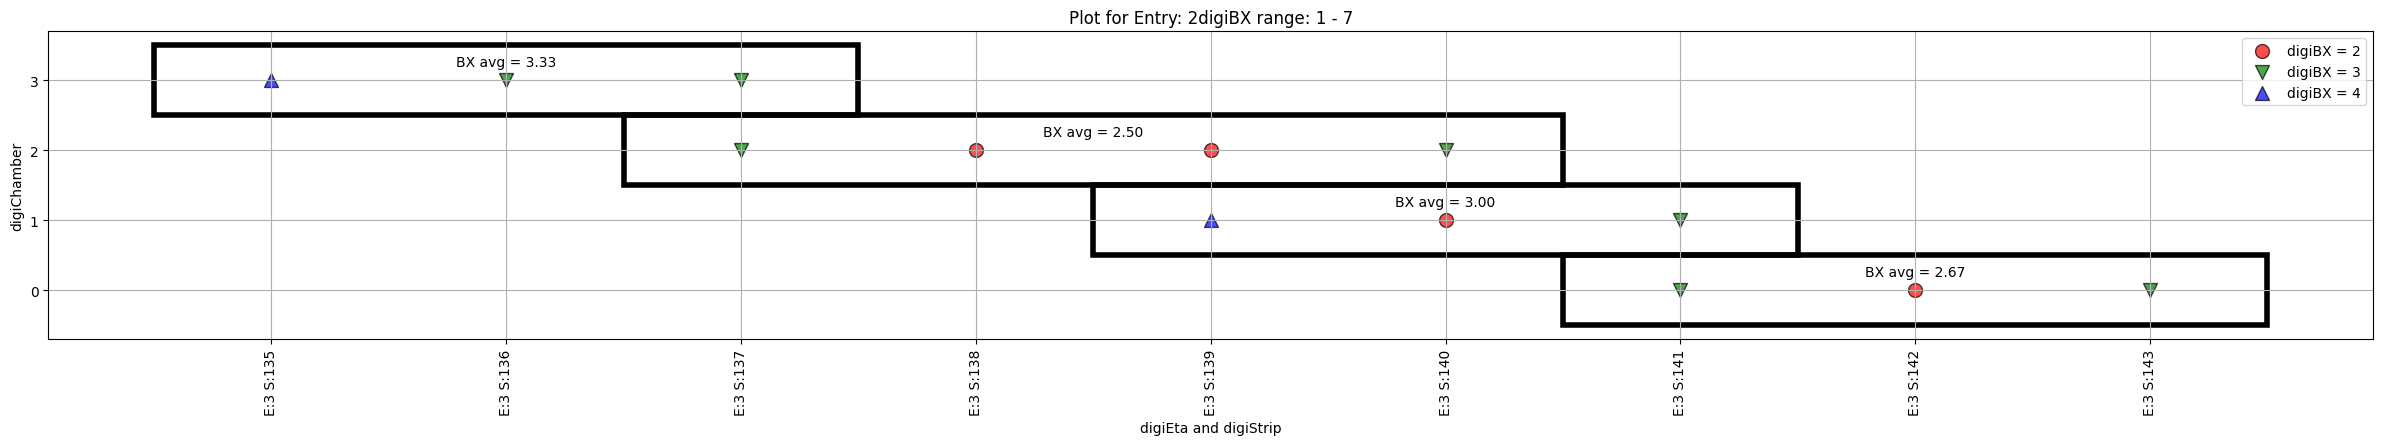

In [180]:
def plot_digi(df: pd.DataFrame, entry: int, min_bx: int, max_bx: int) -> None:
    colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'orange', 'purple', 'pink', 'gray', 'cyan', 'lime', 'maroon', 'navy']
    markers = ['o', 'v', '^', '<', '>', 's', 'p', '*', 'h', 'D', '+', 'x', 'd', '|', '_']

    # Filter dataframe by entry and digiBX range
    df_entry = df[(df['entry'] == entry) & (df['digiBX'] >= min_bx) & (df['digiBX'] <= max_bx)]
    
    # Add a cluster column based on chamber, eta and strip sequence
    df_entry = df_entry.sort_values(['digiChamber', 'digiEta', 'digiStrip'])
    df_entry['cluster'] = (df_entry['digiChamber'].ne(df_entry['digiChamber'].shift()) | 
                           df_entry['digiEta'].ne(df_entry['digiEta'].shift()) | 
                           ~df_entry['digiStrip'].diff().isin([0,1])).cumsum()

    fig, ax = plt.subplots(figsize=(30, 4))
    
    unique_digi_bx = sorted(list(df_entry['digiBX'].unique()))


    for idx, digi_bx in enumerate(unique_digi_bx):
        df_bx = df_entry[df_entry['digiBX'] == digi_bx]
        color = colors[idx % len(colors)]
        marker = markers[idx % len(markers)]
        
        # Check if there are multiple digiBX values for a given Eta, Strip, and Chamber combination
        multiple_bx = df_bx.groupby(['digiChamber', 'digiEta', 'digiStrip']).size().max() > 1
        if multiple_bx:
            color = 'r'
        
        ax.scatter(df_bx['digiStrip'], df_bx['digiChamber'], c=color, 
                   marker=marker, s=100, edgecolor='black', linewidth=1, 
                   label=f'digiBX = {digi_bx}', alpha=0.7)

    # Display cluster rectangles and average digiBX
    cluster_df = df_entry.groupby('cluster').agg({'digiChamber': 'first', 'digiEta': ['min', 'max'], 
                                                  'digiStrip': ['min', 'max'], 'digiBX': 'mean'}).reset_index()

    for _, row in cluster_df.iterrows():
        rectangle = patches.Rectangle((row[('digiStrip', 'min')]-0.5, row[('digiChamber', 'first')]-0.5), 
                              row[('digiStrip', 'max')] - row[('digiStrip', 'min')]+1, 1, 
                              linewidth=4, edgecolor='black', facecolor='none')
        ax.add_patch(rectangle)
        ax.text((row['digiStrip']['min'] + row['digiStrip']['max']) / 2, row['digiChamber'] + 0.2, 
                f"BX avg = {row['digiBX']['mean']:.2f}", horizontalalignment='center')

    plt.yticks(range(0, 4))
    unique_x_labels = df_entry[['digiEta', 'digiStrip']].drop_duplicates()
    ax.set_xticks(unique_x_labels['digiStrip'])
    ax.set_xticklabels(['E:{} S:{}'.format(eta, strip) for eta, strip in zip(unique_x_labels['digiEta'], unique_x_labels['digiStrip'])], rotation=90)

    plt.xlabel('digiEta and digiStrip')
    plt.ylabel('digiChamber')
    plt.title('Plot for Entry: {}'.format(entry) + 'digiBX range: {} - {}'.format(min_bx, max_bx))
    handles, labels = ax.get_legend_handles_labels()
    labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))  # Sort labels and handles
    ax.legend(handles, labels)
    plt.grid(True)
    plt.show()

plot_digi(df, 2, 1, 7)

In [6]:
#Opening cluster .root file and creating dataframes from it's TTrees
file = uproot.open("data/cluster.root")
dataframes_cluster = {}

for key in file.keys():
    if isinstance(file[key], uproot.behaviors.TTree.TTree):
        tree = file[key]
        df_clus = tree.arrays(library="pd")
        dataframes_cluster[key] = df_clus.astype(float)
df_cluster=dataframes_cluster['cluster;1']

In [21]:
df_processed2

,digiCluster_,entry_,digiBX_mean,digiBX_min,digiBX_max,digiBX_second_largest,digiStrip_mean,digiStrip_min,digiStrip_max,digiChamber_first,digiEta_first,good_event,avg_BX
0,1.0,0.0,3.000000,3.0,3.0,3.0,5.5,5.0,6.0,0.0,3.0,False,2.735714
1,1.0,1.0,3.200000,3.0,4.0,3.0,130.0,128.0,132.0,0.0,3.0,False,2.714286
2,1.0,2.0,2.666667,2.0,3.0,3.0,142.0,141.0,143.0,0.0,3.0,True,2.875000
3,1.0,3.0,4.000000,4.0,4.0,4.0,46.0,46.0,46.0,0.0,3.0,True,2.883929
4,1.0,4.0,2.333333,2.0,3.0,2.0,181.0,180.0,182.0,0.0,4.0,False,2.613889
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1647707,285.0,278145.0,3.000000,3.0,3.0,3.0,216.5,216.0,217.0,3.0,4.0,False,2.689858
1647708,286.0,278145.0,2.250000,2.0,3.0,2.0,244.5,243.0,246.0,3.0,4.0,False,2.689858
1647709,287.0,278145.0,2.500000,2.0,3.0,2.0,271.5,271.0,272.0,3.0,4.0,False,2.689858
1647710,288.0,278145.0,2.500000,2.0,3.0,2.0,302.5,302.0,303.0,3.0,4.0,False,2.689858


Fitting parameters: [-0.5  96.25]
Average BX: 3.25


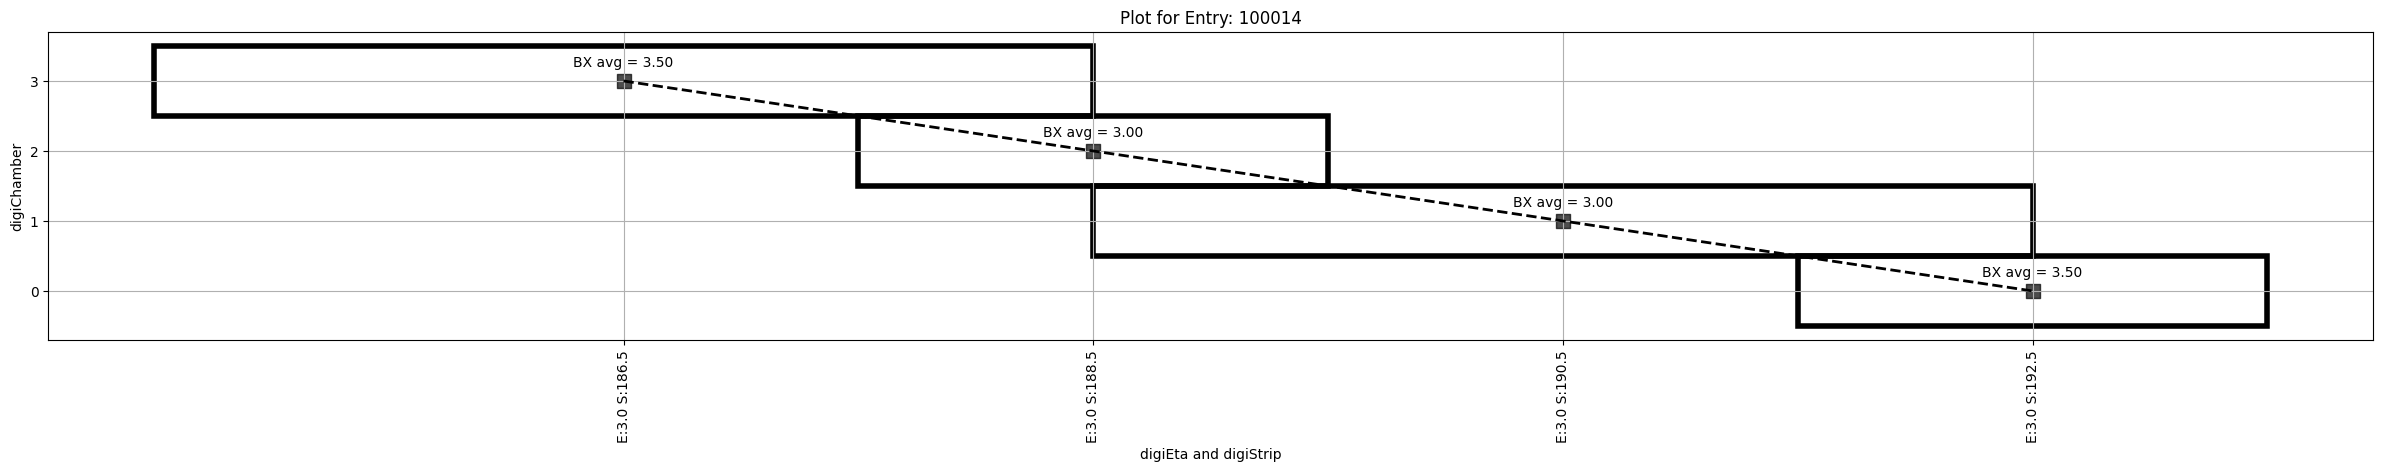

In [406]:
def check_event_fast(df, event):
    # Filter dataframe by event
    df_event = df[df['entry_'] == event]
    
    # Count the number of clusters in each chamber
    cluster_counts = df_event['digiChamber_first'].value_counts().unique()
    
    # Check if there is exactly one cluster in each chamber
    if len(cluster_counts) == 1 and cluster_counts.all() == 1:
        return True
    else:
        return False

def plot_event(df, event):
    if not check_event(df, event):
        print("bad event")
    
    # Filter dataframe by event
    df_event = df[df['entry_'] == event]

    # Prepare data for plotting and fitting
    x = df_event['digiStrip_mean']
    y = df_event['digiChamber_first']
    
    # Fit the points to a line
    coefficients = np.polyfit(x, y, 1)
    poly = np.poly1d(coefficients)
    x_fit = np.linspace(x.min(), x.max(), 100)
    y_fit = poly(x_fit)

    # Plot style configuration
#     colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'orange', 'purple', 'pink', 'gray', 'cyan', 'lime', 'maroon', 'navy']
#     markers = ['o', 'v', '^', '<', '>', 's', 'p', '*', 'h', 'D', '+', 'x', 'd', '|', '_']

    fig, ax = plt.subplots(figsize=(30, 4))
    
    for idx, row in df_event.iterrows():
        ax.scatter(row['digiStrip_mean'], row['digiChamber_first'], c='black', 
                   marker='s', s=100, edgecolor='black', linewidth=1,
                   alpha=0.7)
        rectangle = patches.Rectangle((row['digiStrip_min']-0.5, row['digiChamber_first']-0.5), 
                                      row['digiStrip_max'] - row['digiStrip_min']+1, 1, 
                                      linewidth=4, edgecolor='black', facecolor='none')
        ax.add_patch(rectangle)
        ax.text(row['digiStrip_mean'], row['digiChamber_first'] + 0.2, 
                f"BX avg = {row['digiBX_mean']:.2f}", horizontalalignment='center')
    
    # Plot fitted line
    ax.plot(x_fit, y_fit, color='black', linewidth=2, linestyle='--')

    plt.yticks(range(0, 4))
    ax.set_xticks(df_event['digiStrip_mean'])
    ax.set_xticklabels([f"E:{row['digiEta_first']} S:{row['digiStrip_mean']}" for _, row in df_event.iterrows()], rotation=90)

    plt.xlabel('digiEta and digiStrip')
    plt.ylabel('digiChamber')
    plt.title(f'Plot for Entry: {event}')
    
    # Print fitting parameters
    print(f"Fitting parameters: {coefficients}")
    
    # Print average BX
    avg_bx = df_event['digiBX_mean'].mean()
    print(f"Average BX: {avg_bx}")
    
    plt.grid(True)
    plt.show()

plot_event(df_cluster, 100014)

In [12]:
def create_cluster_df(df: pd.DataFrame, entry_range: tuple = None, bx_range: tuple = None, filename: str = 'cluster.root') -> None:
    # If entry range is provided, filter dataframe by entry range
    if entry_range:
        df = df[(df['entry'] >= entry_range[0]) & (df['entry'] <= entry_range[1])]
    
    # If BX range is provided, filter dataframe by BX range
    if bx_range:
        df = df[(df['digiBX'] >= bx_range[0]) & (df['digiBX'] <= bx_range[1])]
    
    # Sort values by 'entry', 'digiChamber', 'digiEta', 'digiStrip'
    df = df.sort_values(['entry', 'digiChamber', 'digiEta', 'digiStrip'])

    # Define a function for creating clusters within a group
    def cluster_group(g):
        g['digiCluster'] = (g['digiChamber'].ne(g['digiChamber'].shift()) | 
                            g['digiEta'].ne(g['digiEta'].shift()) | 
                            ~g['digiStrip'].diff().isin([0,1])).cumsum()
        return g

    # Apply the cluster_group function to each 'entry' group
    df = df.groupby('entry').apply(cluster_group)

    def second_largest(series):
        if len(series) < 2:
            return series.nlargest(1).iloc[-1]
        else:
            return series.nlargest(2).iloc[-1]

    cluster_df = df.groupby(['digiCluster', 'entry']).agg({
        'digiBX': ['mean', 'min', 'max', second_largest],
        'digiStrip': ['mean', 'min', 'max'],
        'digiChamber': 'first',
        'digiEta': 'first'
    }).reset_index()
    cluster_df.columns = ['_'.join(col) for col in cluster_df.columns]
    # Create a ROOT file
    root_file = ROOT.TFile(filename, "RECREATE")

    # Create a tree
    tree = ROOT.TTree("cluster", "cluster")

    # Define variables to hold the values for each branch
    data = {column: array.array('d', [0]) for column in cluster_df.columns}

    # Create the branches
    for column in cluster_df.columns:
        tree.Branch(column, data[column], f"{column}/D")

    # Fill the tree
    for i in range(cluster_df.shape[0]):
        for column in cluster_df.columns:
            data[column][0] = cluster_df.at[i, column]
        tree.Fill()

    # Write the tree into the ROOT file and close it
    tree.Write()
    root_file.Close()




# Usage:
create_cluster_df(df, bx_range = (0, 7), filename = 'data/cluster.root')
file = uproot.open("data/cluster.root")
dataframes_cluster = {}

for key in file.keys():
    if isinstance(file[key], uproot.behaviors.TTree.TTree):
        tree = file[key]
        df_clus = tree.arrays(library="pd")
        dataframes_cluster[key] = df_clus.astype(float)
df_cluster2=dataframes_cluster['cluster;1']




/var/folders/nw/8dk2cczn3fdbjmqybvvdjykc0000gn/T/ipykernel_90461/3859800689.py:21: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df = df.groupby('entry').apply(cluster_group)


In [13]:
def process_df_fast(df):
    # Group by event and chamber, and count the number of clusters in each chamber
    cluster_counts = df.groupby(['entry_', 'digiChamber_first'])['digiCluster_'].count()
    
    # Check if there is exactly one cluster in each chamber for each event
    good_events = cluster_counts.groupby('entry_').apply(lambda x: all(x == 1))
    
    # Add column for good/bad event
    df['good_event'] = good_events[df['entry_']].values
    
    # Add column for average BX
    df['avg_BX'] = df.groupby('entry_')['digiBX_mean'].transform('mean')
    
    return df

# Example usage
df_processed2 = process_df_fast(df_cluster2)

In [18]:
df_processed2[df_processed2['entry_'] == 1]

,digiCluster_,entry_,digiBX_mean,digiBX_min,digiBX_max,digiBX_second_largest,digiStrip_mean,digiStrip_min,digiStrip_max,digiChamber_first,digiEta_first,good_event,avg_BX
1,1.0,1.0,3.2,3.0,4.0,3.0,130.0,128.0,132.0,0.0,3.0,False,2.714286
300233,2.0,1.0,3.0,3.0,3.0,3.0,189.0,186.0,192.0,0.0,3.0,False,2.714286
598738,3.0,1.0,3.0,3.0,3.0,3.0,131.5,131.0,132.0,1.0,3.0,False,2.714286
895657,4.0,1.0,2.4,2.0,3.0,3.0,188.0,186.0,190.0,1.0,3.0,False,2.714286
1156167,5.0,1.0,2.0,2.0,2.0,2.0,133.0,133.0,133.0,2.0,3.0,False,2.714286
1249303,6.0,1.0,1.4,1.0,2.0,2.0,186.0,184.0,188.0,2.0,3.0,False,2.714286
1294018,7.0,1.0,4.0,3.0,5.0,3.0,184.5,184.0,185.0,3.0,3.0,False,2.714286


In [11]:
df_cluste2r[df_cluste2r['e_n_t_r_y']==2]

,d_i_g_i_C_l_u_s_t_e_r,e_n_t_r_y,d_i_g_i_B_X___m_e_a_n,d_i_g_i_B_X___m_i_n,d_i_g_i_B_X___m_a_x,d_i_g_i_B_X___s_e_c_o_n_d___l_a_r_g_e_s_t,d_i_g_i_S_t_r_i_p___m_e_a_n,d_i_g_i_S_t_r_i_p___m_i_n,d_i_g_i_S_t_r_i_p___m_a_x,d_i_g_i_C_h_a_m_b_e_r___f_i_r_s_t,d_i_g_i_E_t_a___f_i_r_s_t
2,1.0,2.0,2.846154,2.0,4.0,4.0,139.076923,135.0,143.0,0.0,3.0


Slope: -0.028169014084507043, Intercept: 5.746478873239436
Average BX: 2.613888888888889


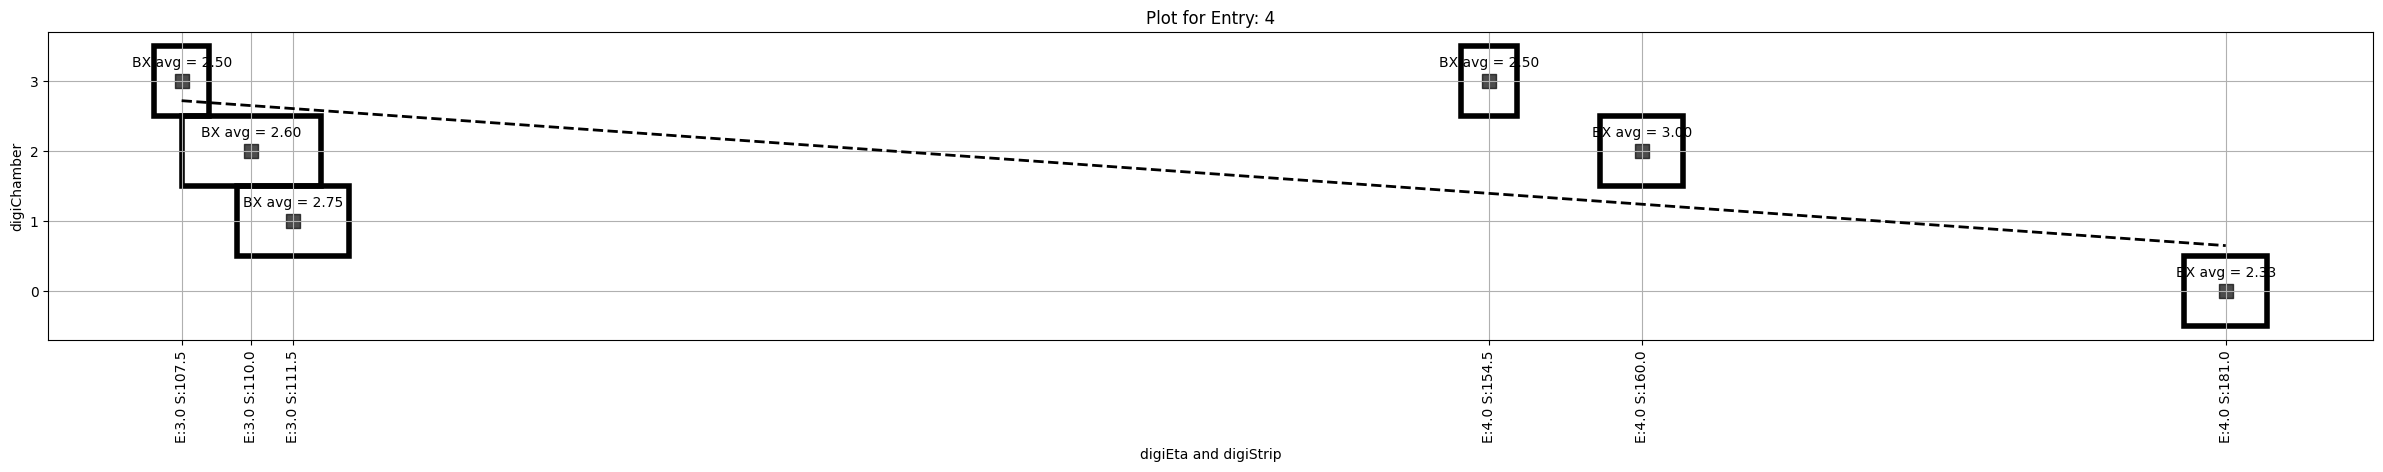

In [457]:
def check_event_fast(df, event):
    # Filter dataframe by event
    df_event = df[df['entry_'] == event]
    
    # Count the number of clusters in each chamber
    cluster_counts = df_event['digiChamber_first'].value_counts().unique()
    # Check if there is exactly one cluster in each chamber
    if len(cluster_counts) == 1 and cluster_counts[0] == 1 and cluster_counts[1] == 1 and cluster_counts[0] == 2 and cluster_counts[0] == 3:
        return True
    else:
        return False
def plot_event(df, event):
    # if not check_event_fast(df, event):
    #     print("bad event")
    #     return

    # Filter dataframe by event
    df_event = df[df['entry_'] == event]

    # Prepare data for plotting and fitting
    x = df_event['digiStrip_mean']
    y = df_event['digiChamber_first']

    # Fit the points to a line
    slope, intercept, _, _ = stats.theilslopes(y, x, 0.95) # Theil-Sen estimator
    x_fit = np.linspace(x.min(), x.max(), 100)
    y_fit = slope * x_fit + intercept

    # Plot style configuration
    fig, ax = plt.subplots(figsize=(30, 4))

    for idx, row in df_event.iterrows():
        ax.scatter(row['digiStrip_mean'], row['digiChamber_first'], c='black', 
                   marker='s', s=100, edgecolor='black', linewidth=1,
                   alpha=0.7)
        rectangle = patches.Rectangle((row['digiStrip_min']-0.5, row['digiChamber_first']-0.5), 
                                      row['digiStrip_max'] - row['digiStrip_min']+1, 1, 
                                      linewidth=4, edgecolor='black', facecolor='none')
        ax.add_patch(rectangle)
        ax.text(row['digiStrip_mean'], row['digiChamber_first'] + 0.2, 
                f"BX avg = {row['digiBX_mean']:.2f}", horizontalalignment='center')

    # Plot fitted line
    ax.plot(x_fit, y_fit, color='black', linewidth=2, linestyle='--')

    plt.yticks(range(0, 4))
    ax.set_xticks(df_event['digiStrip_mean'])
    ax.set_xticklabels([f"E:{row['digiEta_first']} S:{row['digiStrip_mean']}" for _, row in df_event.iterrows()], rotation=90)

    plt.xlabel('digiEta and digiStrip')
    plt.ylabel('digiChamber')
    plt.title(f'Plot for Entry: {event}')

    # Print fitting parameters
    print(f"Slope: {slope}, Intercept: {intercept}")

    # Print average BX
    avg_bx = df_event['digiBX_mean'].mean()
    print(f"Average BX: {avg_bx}")

    plt.grid(True)
    plt.show()
plot_event(df_cluster, 4)

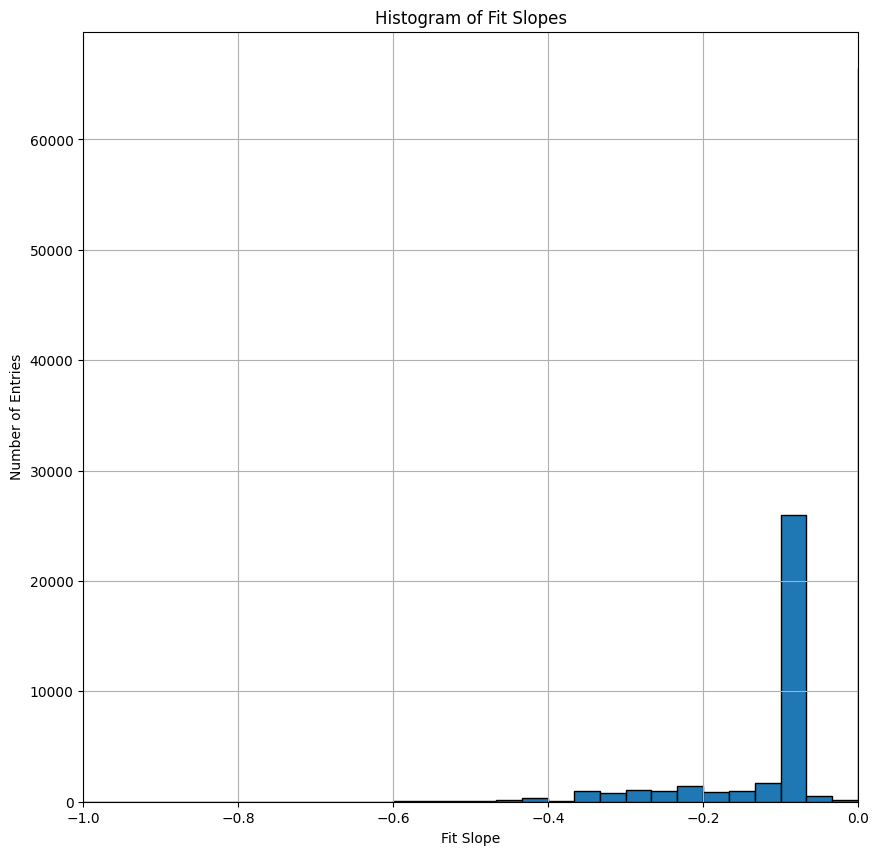

In [22]:
def calculate_slope(df):
    slopes = []
    # Choose god events
    df = df[df['good_event'] == True]

    # Group by event
    grouped = df.groupby('entry_')

    for name, group in grouped:
        
        x = group['digiStrip_mean'].values
        y = group['digiBX_second_largest'].values
        # Check if there are enough unique points to fit
        if len(np.unique(x)) > 3:
            # Calculate Median Absolute Deviation
            # MAD = stats.median_abs_deviation(y, scale='normal')
            # median = np.median(y)
            # if any(abs(y - median) > 2 * MAD):  # if any y-value is an outlier
            #     continue  # skip this group
            
            slope, intercept, _, _ = stats.theilslopes(y, x, 0.95) # Theil-Sen estimator
            
            slopes.append(slope)
            # if slope < -0.6:
            #     plot_event(df, name)

    return slopes

def plot_slope(df):
    # Calculate slopes
    slopes = calculate_slope(df)
    
    # Create histogram
    fig, ax = plt.subplots(figsize=(10, 10))
    
    ax.hist(slopes, bins=100, edgecolor='black')  # Choose a suitable number of bins
    ax.set_xlim(-1, 0)
    ax.set_xlabel('Fit Slope')
    ax.set_ylabel('Number of Entries')
    ax.set_title('Histogram of Fit Slopes')
    plt.grid(True)
    plt.show()
plot_slope(df_processed2)


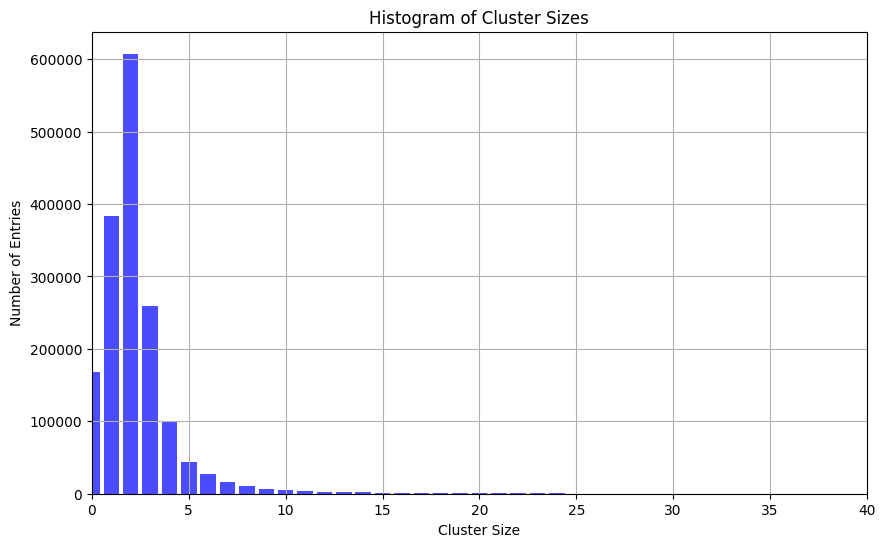

In [357]:
def plot_cluster_histogram(df):
    # Calculate the size of each cluster
    
    df['cluster_size'] = abs(df['digiStrip_max'] - df['digiStrip_min'])

    # Count frequencies of each cluster size
    size_counts = df['cluster_size'].value_counts()

    # Create histogram
    plt.figure(figsize=(10, 6))
    plt.bar(size_counts.index, size_counts.values, color='blue', alpha=0.7)

    plt.title('Histogram of Cluster Sizes')
    plt.xlabel('Cluster Size')
    plt.xlim(0, 40)
    plt.ylabel('Number of Entries')
    plt.grid(True)
    plt.show()

plot_cluster_histogram(df_cluster)

/var/folders/nw/8dk2cczn3fdbjmqybvvdjykc0000gn/T/ipykernel_5529/62780074.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cluster_size'] = abs(df['digiStrip_max'] - df['digiStrip_min'])


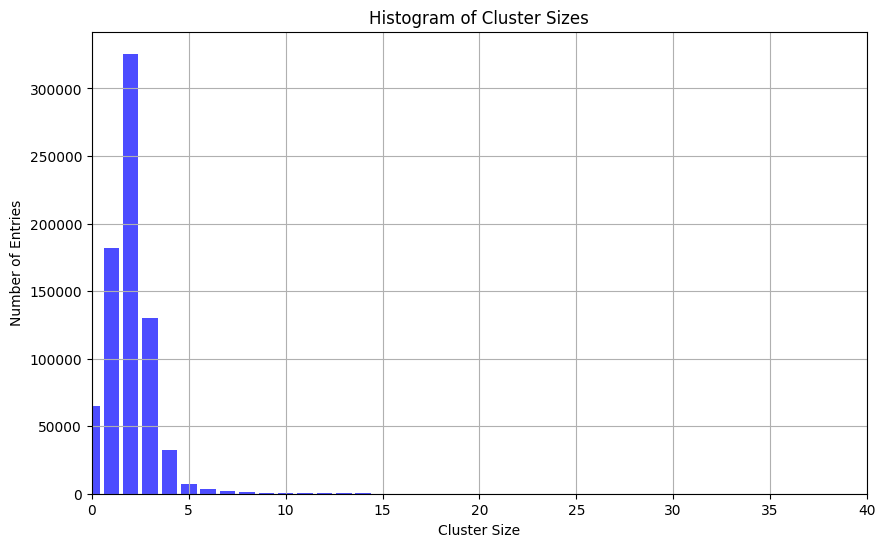

In [419]:
def plot_cluster_histogram(df):
    df = df[df['good_event'] == True]
    # Calculate the size of each cluster
    df['cluster_size'] = abs(df['digiStrip_max'] - df['digiStrip_min'])

    # Count frequencies of each cluster size
    size_counts = df['cluster_size'].value_counts()

    # Create histogram
    plt.figure(figsize=(10, 6))
    plt.bar(size_counts.index, size_counts.values, color='blue', alpha=0.7)

    plt.title('Histogram of Cluster Sizes')
    plt.xlabel('Cluster Size')
    plt.xlim(0, 40)
    plt.ylabel('Number of Entries')
    plt.grid(True)
    plt.show()

plot_cluster_histogram(df_cluster)

In [ ]:
def plot_cluster_histogram(df):
    # Calculate the size of each cluster
    df['cluster_size'] = abs(df['digiStrip_max'] - df['digiStrip_min'])

    # Count frequencies of each cluster size
    size_counts = df['cluster_size'].value_counts()

    # Create histogram
    plt.figure(figsize=(10, 6))
    plt.bar(size_counts.index, size_counts.values, color='blue', alpha=0.7)

    plt.title('Histogram of Cluster Sizes')
    plt.xlabel('Cluster Size')
    plt.ylabel('Number of Entries')
    plt.grid(True)
    plt.show()

plot_cluster_size_histogram(df_cluster)

In [43]:
def process_df_fast(df):
    # Group by event and chamber, and count the number of clusters in each chamber
    cluster_counts = df.groupby(['entry_', 'digiChamber_first'])['digiCluster_'].count()
    
    # Check if there is exactly one cluster in each chamber for each event
    good_events = cluster_counts.groupby('entry_').apply(lambda x: all(x == 1))
    
    # Add column for good/bad event
    df['good_event'] = good_events[df['entry_']].values
    
    # Add column for average BX
    df['avg_BX'] = df.groupby('entry_')['digiBX_mean'].transform('mean')
    
    return df

# Example usage
df_processed = process_df_fast(df_cluster)

events are processed
BX is processed


In [509]:
df_processed[df_processed['digiStrip_min'] == 130]

,digiCluster_,entry_,digiBX_mean,digiBX_min,digiBX_max,digiStrip_mean,digiStrip_min,digiStrip_max,digiChamber_first,digiEta_first,good_event,avg_BX,cluster_size
67,1.0,69.0,2.666667,2.0,3.0,131.0,130.0,132.0,1.0,3.0,True,2.888889,2.0
207,1.0,211.0,2.750000,2.0,3.0,131.5,130.0,133.0,0.0,3.0,False,2.555556,3.0
470,1.0,482.0,3.000000,3.0,3.0,130.5,130.0,131.0,0.0,3.0,True,2.312500,1.0
594,1.0,608.0,3.000000,3.0,3.0,130.5,130.0,131.0,0.0,3.0,True,2.395833,1.0
605,1.0,620.0,2.500000,2.0,3.0,131.5,130.0,133.0,1.0,3.0,True,2.666667,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1645993,195.0,298394.0,4.000000,4.0,4.0,130.5,130.0,131.0,3.0,3.0,False,3.544868,1.0
1646602,207.0,99409.0,3.333333,3.0,4.0,131.0,130.0,132.0,2.0,4.0,False,2.895350,2.0
1646708,209.0,242715.0,4.000000,4.0,4.0,131.0,130.0,132.0,2.0,4.0,False,3.593185,2.0
1646776,211.0,67688.0,3.400000,3.0,4.0,132.0,130.0,134.0,3.0,3.0,False,2.579943,4.0


In [464]:
df_cluster[df_cluster['entry_'] == 1]

,digiCluster_,entry_,digiBX_mean,digiBX_min,digiBX_max,digiStrip_mean,digiStrip_min,digiStrip_max,digiChamber_first,digiEta_first,good_event,avg_BX,cluster_size
1,1.0,1.0,3.2,3.0,4.0,130.0,128.0,132.0,0.0,3.0,False,2.714286,4.0
300233,2.0,1.0,3.0,3.0,3.0,189.0,186.0,192.0,0.0,3.0,False,2.714286,6.0
598738,3.0,1.0,3.0,3.0,3.0,131.5,131.0,132.0,1.0,3.0,False,2.714286,1.0
895657,4.0,1.0,2.4,2.0,3.0,188.0,186.0,190.0,1.0,3.0,False,2.714286,4.0
1156167,5.0,1.0,2.0,2.0,2.0,133.0,133.0,133.0,2.0,3.0,False,2.714286,0.0
1249303,6.0,1.0,1.4,1.0,2.0,186.0,184.0,188.0,2.0,3.0,False,2.714286,4.0
1294018,7.0,1.0,4.0,3.0,5.0,184.5,184.0,185.0,3.0,3.0,False,2.714286,1.0


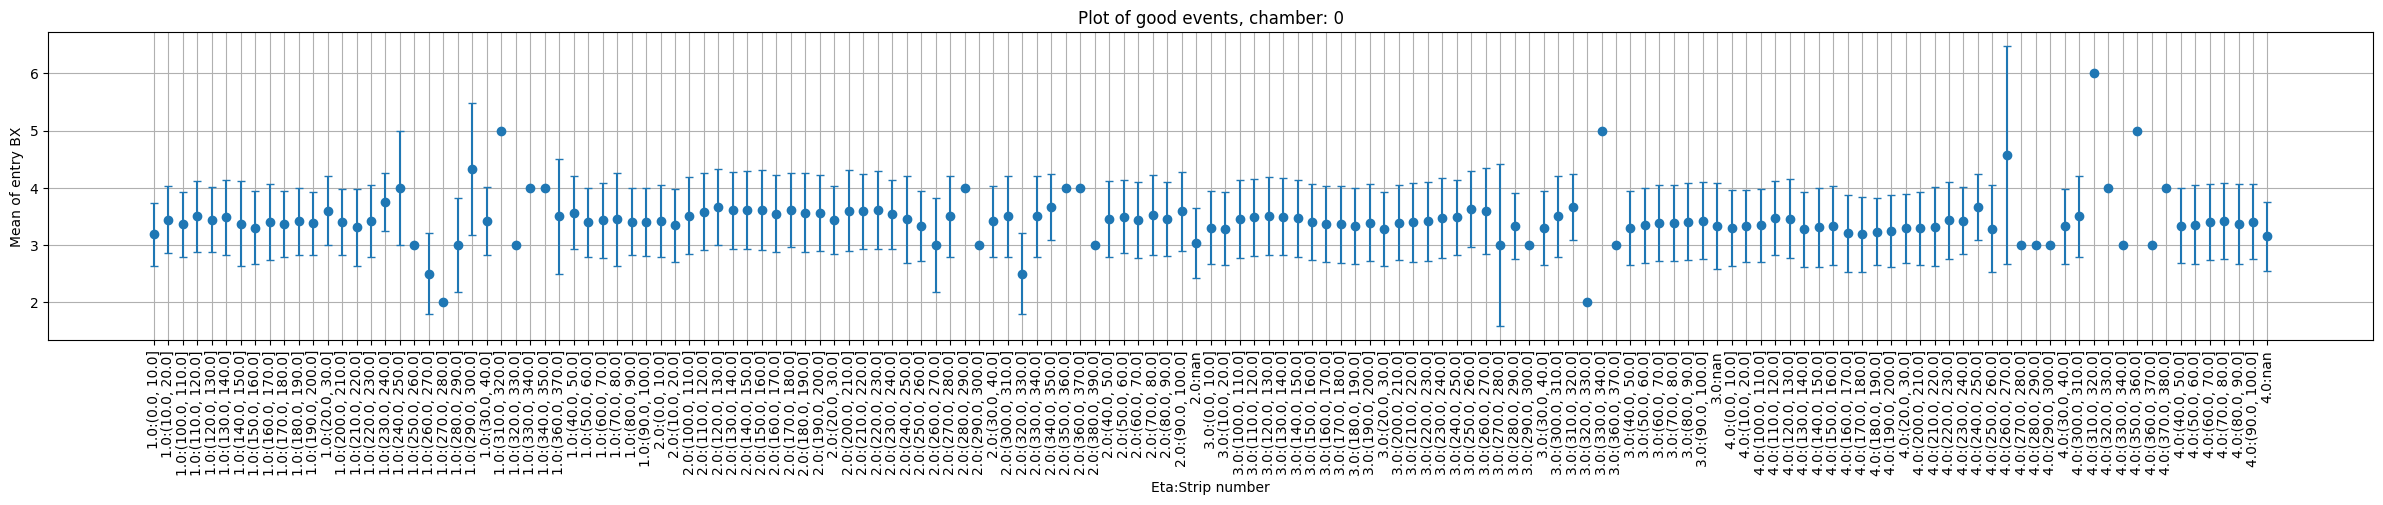

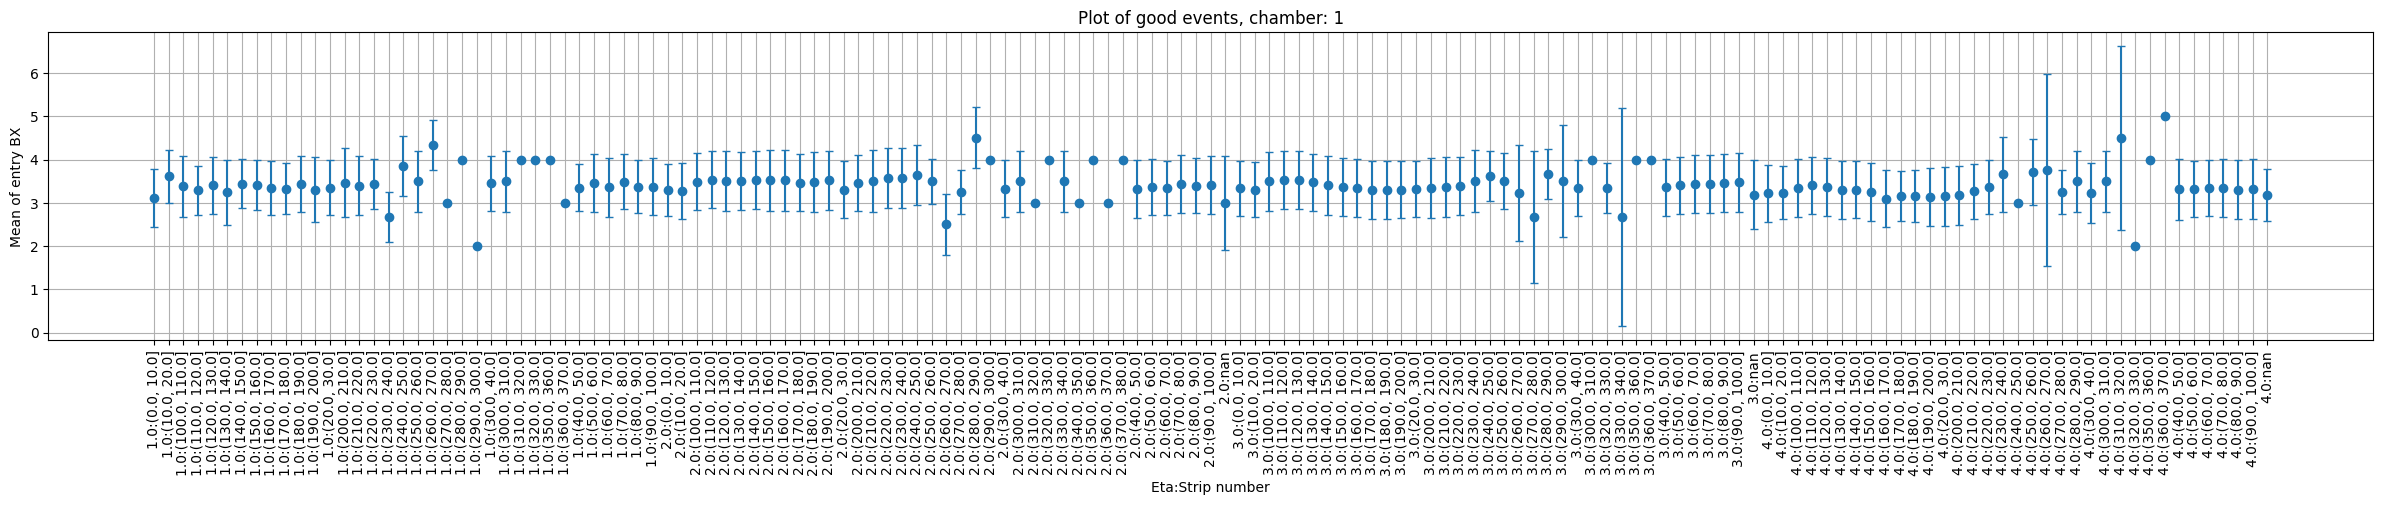

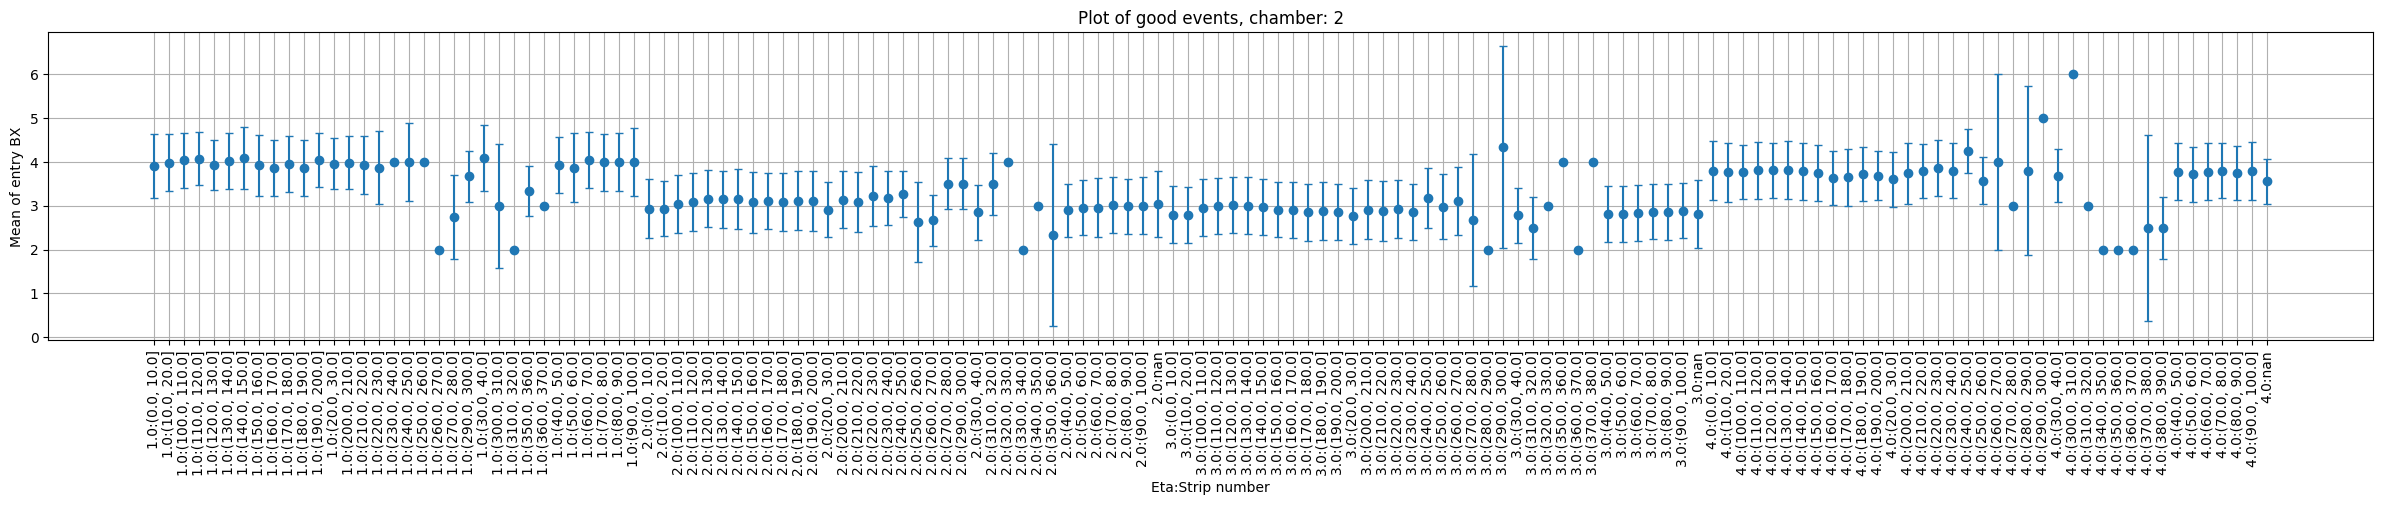

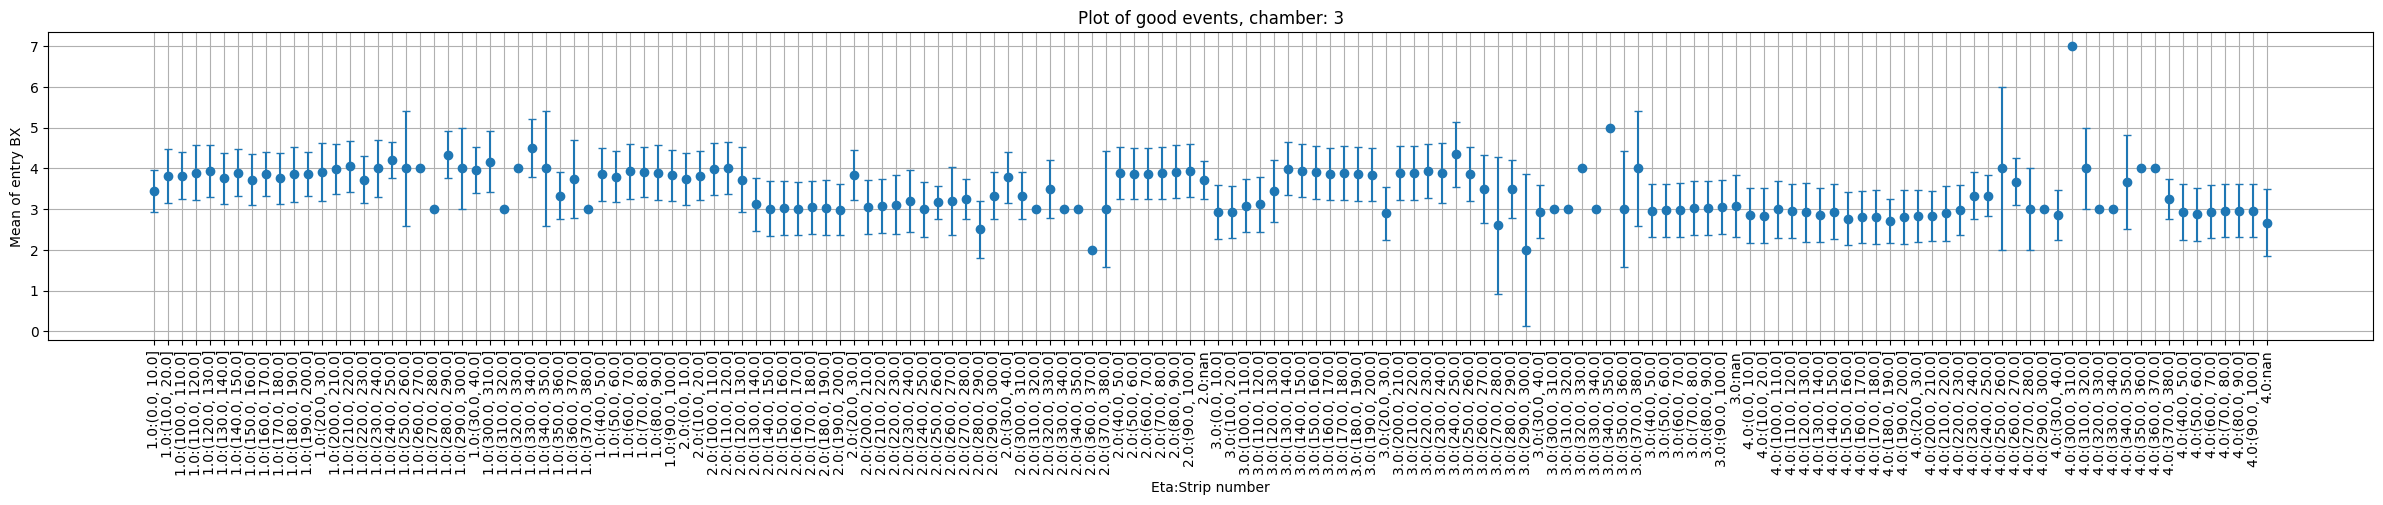

In [26]:
#On X axe we have average digiStrip_mean(which corresponds to CLUSTER) within selected bin width, y - average entry BX.
def plot_good_events(df, chamber, strip_bin_width):
    # Filter out events marked as bad
    df = df[df['good_event']].copy()
    df = df[df['digiChamber_first']==chamber]
    fig, ax = plt.subplots(figsize=(30, 4))
    # Create bins for strip
    df['strip_bin'] = pd.cut(df['digiStrip_mean'], np.arange(0, df['digiStrip_mean'].max() + strip_bin_width, strip_bin_width))

    # Create a combined column for 'digiEta_first' and 'strip_bin'
    df['eta_strip'] = df['digiEta_first'].astype(str) + ':' + df['strip_bin'].astype(str)
    
    # Calculate mean and std of avg_BX for each eta_strip bin
    grouped = df.groupby('eta_strip')['digiBX_max'].agg(['mean', 'std'])

    # We sort the index to maintain the order of Eta and Strip while plotting
    grouped = grouped.sort_index()

    # Plot the data with error bars
    plt.errorbar(grouped.index, grouped['mean'], yerr=grouped['std'], fmt='o', capsize=3)

    plt.xticks(rotation=90) # This will rotate x-axis labels for better readability
    # plt.yticks(range(0, 4))
    plt.xlabel('Eta:Strip number')
    plt.ylabel('Mean of entry BX')
    plt.title(f'Plot of good events, chamber: {chamber}')
    plt.grid(True)
    plt.show()

for i in range(0, 4):
    plot_good_events(df_processed2,i, 10)

In [ ]:
df_cluster_processed['digiBX_mean']

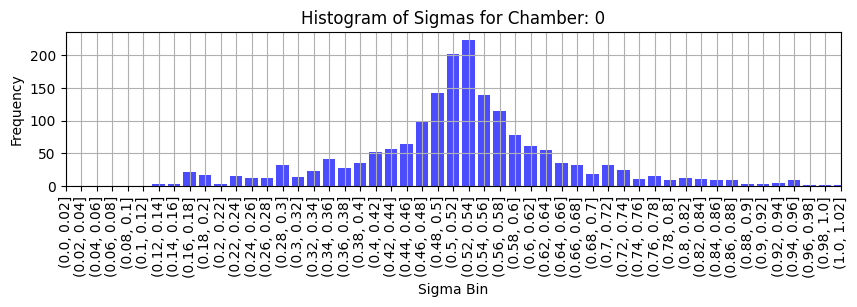

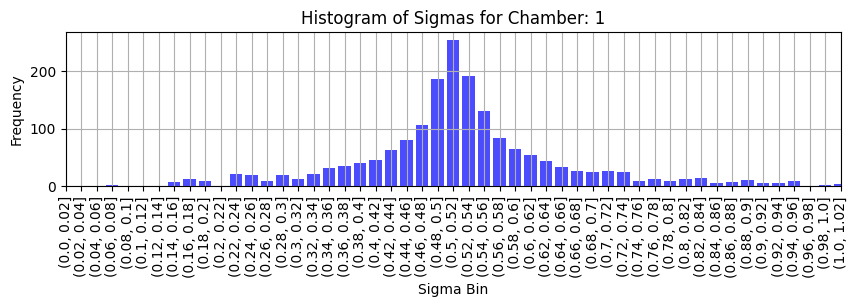

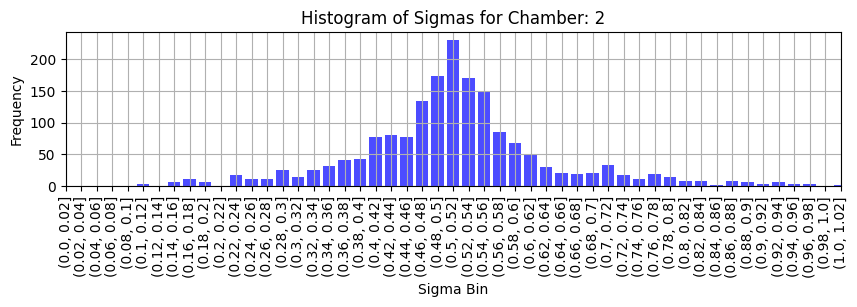

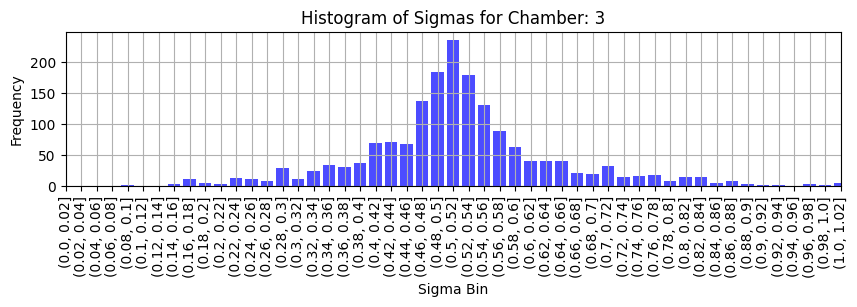

In [499]:
def plot_sigmas_histogram(df, chamber, sigma_bin_width):
    # Filter out events marked as bad
    df = df[df['good_event']].copy()
    df = df[df['digiChamber_first']==chamber]
    
    # Create a combined column for 'digiEta_first' and 'digiStrip_mean'
    df['eta_strip'] = df['digiEta_first'].astype(str) + ':' + df['digiStrip_mean'].astype(str)
    
    # Calculate mean and std of avg_BX for each eta_strip bin
    grouped = df.groupby('eta_strip')['digiBX_mean'].agg(['mean', 'std'])
    # Define the bins according to the sigma_bin_width
    bins = np.arange(grouped['std'].min(), grouped['std'].max(), sigma_bin_width)

    # Create a new column 'sigma_bin' which represents the bin of each 'eta_strip' 
    grouped['sigma_bin'] = pd.cut(grouped['std'], bins=bins)

    # Group by 'sigma_bin' and calculate the count
    histogram_data = grouped.groupby('sigma_bin').size()

    # Plot the histogram
    plt.figure(figsize=(10, 2))
    plt.bar(histogram_data.index.astype(str), histogram_data.values, color='blue', alpha=0.7)
    plt.title('Histogram of Sigmas for Chamber: '+str(chamber))
    plt.xlim(0, 50)
    plt.xlabel('Sigma Bin')
    plt.ylabel('Frequency')
    plt.xticks(rotation=90)
    plt.grid(True)
    plt.show()

# Usage
for i in range(4):
    plot_sigmas_histogram(df_processed2, i, 0.02)

/var/folders/nw/8dk2cczn3fdbjmqybvvdjykc0000gn/T/ipykernel_90461/3655058584.py:25: DeprecationWarning: `median_absolute_deviation` is deprecated, use `median_abs_deviation` instead!

To preserve the existing default behavior, use
`scipy.stats.median_abs_deviation(..., scale=1/1.4826)`.
The value 1.4826 is not numerically precise for scaling
with a normal distribution. For a numerically precise value, use
`scipy.stats.median_abs_deviation(..., scale='normal')`.

  std = median_absolute_deviation(finite_values)


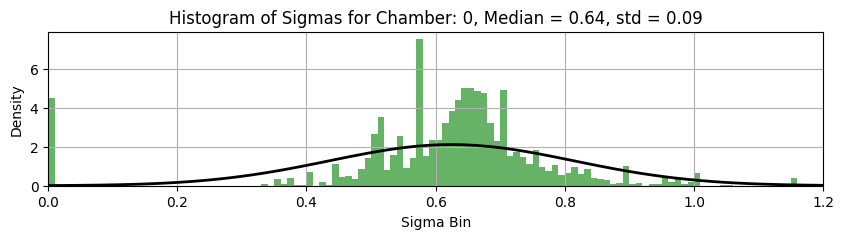

/var/folders/nw/8dk2cczn3fdbjmqybvvdjykc0000gn/T/ipykernel_90461/3655058584.py:25: DeprecationWarning: `median_absolute_deviation` is deprecated, use `median_abs_deviation` instead!

To preserve the existing default behavior, use
`scipy.stats.median_abs_deviation(..., scale=1/1.4826)`.
The value 1.4826 is not numerically precise for scaling
with a normal distribution. For a numerically precise value, use
`scipy.stats.median_abs_deviation(..., scale='normal')`.

  std = median_absolute_deviation(finite_values)


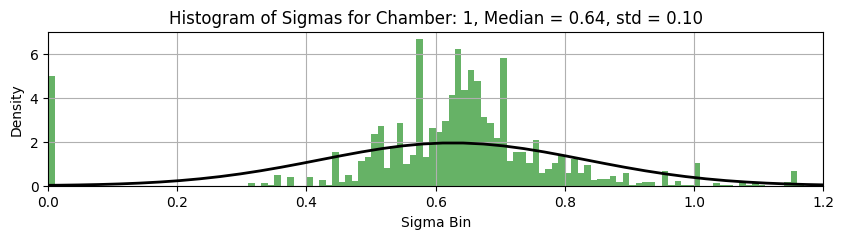

/var/folders/nw/8dk2cczn3fdbjmqybvvdjykc0000gn/T/ipykernel_90461/3655058584.py:25: DeprecationWarning: `median_absolute_deviation` is deprecated, use `median_abs_deviation` instead!

To preserve the existing default behavior, use
`scipy.stats.median_abs_deviation(..., scale=1/1.4826)`.
The value 1.4826 is not numerically precise for scaling
with a normal distribution. For a numerically precise value, use
`scipy.stats.median_abs_deviation(..., scale='normal')`.

  std = median_absolute_deviation(finite_values)


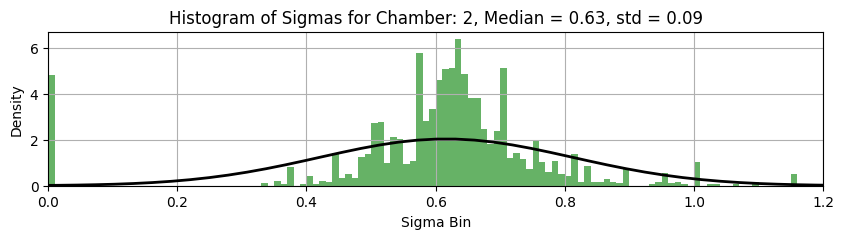

/var/folders/nw/8dk2cczn3fdbjmqybvvdjykc0000gn/T/ipykernel_90461/3655058584.py:25: DeprecationWarning: `median_absolute_deviation` is deprecated, use `median_abs_deviation` instead!

To preserve the existing default behavior, use
`scipy.stats.median_abs_deviation(..., scale=1/1.4826)`.
The value 1.4826 is not numerically precise for scaling
with a normal distribution. For a numerically precise value, use
`scipy.stats.median_abs_deviation(..., scale='normal')`.

  std = median_absolute_deviation(finite_values)


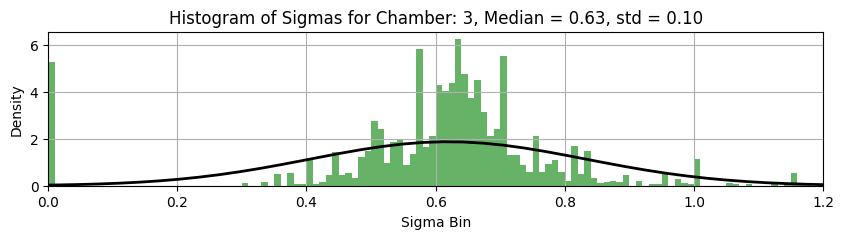

In [27]:
from scipy.stats import norm, median_absolute_deviation

def plot_sigmas_histogram_with_gaussian_fit(df, chamber, sigma_bin_width):
    # Filter out events marked as bad
    df = df[df['good_event']].copy()
    df = df[df['digiChamber_first']==chamber]

    # Create a combined column for 'digiEta_first' and 'digiStrip_mean'
    df['eta_strip'] = df['digiEta_first'].astype(str) + ':' + df['digiStrip_mean'].astype(str)
    
    # Calculate mean and std of avg_BX for each eta_strip bin
    grouped = df.groupby('eta_strip')['digiBX_max'].agg(['mean', 'std'])

    # Define the bins according to the sigma_bin_width
    bins = np.arange(grouped['std'].min(), grouped['std'].max(), sigma_bin_width)

    # Create a new column 'sigma_bin' which represents the bin of each 'eta_strip' 
    grouped['sigma_bin'] = pd.cut(grouped['std'], bins=bins)

    # Filter finite values before fit
    finite_values = grouped['std'][np.isfinite(grouped['std'])]

    # Median and std in same units as x-axis
    median = finite_values.median()
    std = median_absolute_deviation(finite_values)

    # Fit a Gaussian to the sigma data
    mu, sigma = norm.fit(finite_values)

    # Plot the histogram
    plt.figure(figsize=(10, 2))
    plt.hist(grouped['std'], bins=bins, density=True, alpha=0.6, color='g')

    # Plot the Gaussian fit
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, sigma)
    plt.plot(x, p, 'k', linewidth=2)
    plt.xlim(0, 1.2)
    plt.title('Histogram of Sigmas for Chamber: '+str(chamber)+', Median = {:.2f}, std = {:.2f}'.format(median, std))
    plt.xlabel('Sigma Bin')
    plt.ylabel('Density')
    plt.grid(True)
    plt.show()

# Usage
for i in range(4):
    plot_sigmas_histogram_with_gaussian_fit(df_processed2, i, 0.01)


In [31]:
def fraction_of_good_events(df_processed):
    # Filter out events marked as bad
    df = df_processed
    
    # Calculate the fraction of good events
    fraction = df['good_event'].sum() / df.shape[0]
    print('Fraction of good events: {:.2f}'.format(fraction))
fraction_of_good_events(df_processed2)


Fraction of good events: 0.46


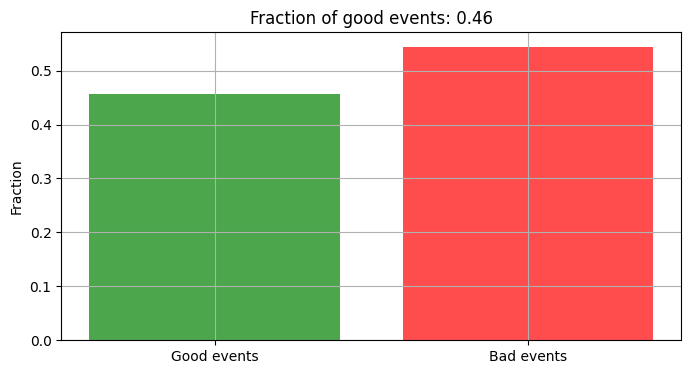

In [37]:
def plot_good_events_vs_bad_events(df_processed):
    # Filter out events marked as bad
    df = df_processed
    
    # Calculate the fraction of good events
    fraction = df['good_event'].sum() / df.shape[0]
    
    # Plot the data
    plt.figure(figsize=(8, 4))
    plt.bar(['Good events', 'Bad events'], [fraction, 1-fraction], color=['green', 'red'], alpha=0.7)
    plt.title(f'Fraction of good events: {fraction:.2f}')
    plt.ylabel('Fraction')
    plt.grid(True)
    plt.show()
plot_good_events_vs_bad_events(df_processed2)

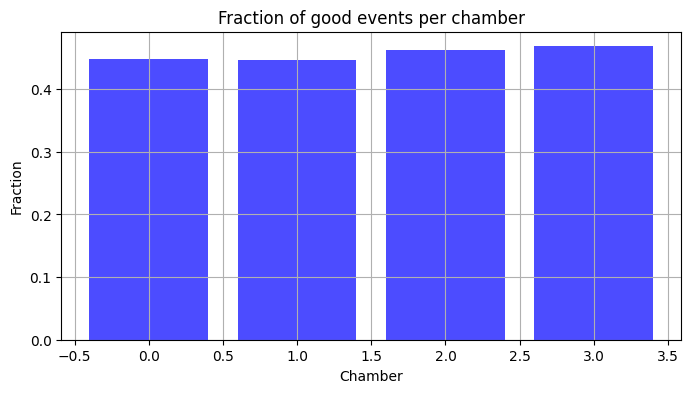

In [38]:
def plot_good_events_vs_bad_events_per_chamber(df_processed):
    # Filter out events marked as bad
    df = df_processed
    
    # Group by chamber and calculate the fraction of good events
    grouped = df.groupby('digiChamber_first')['good_event'].agg(['sum', 'count'])
    grouped['fraction'] = grouped['sum'] / grouped['count']
    
    # Plot the data
    plt.figure(figsize=(8, 4))
    plt.bar(grouped.index, grouped['fraction'], color='blue', alpha=0.7)
    plt.title('Fraction of good events per chamber')
    plt.xlabel('Chamber')
    plt.ylabel('Fraction')
    plt.grid(True)
    plt.show()
plot_good_events_vs_bad_events_per_chamber(df_processed2)

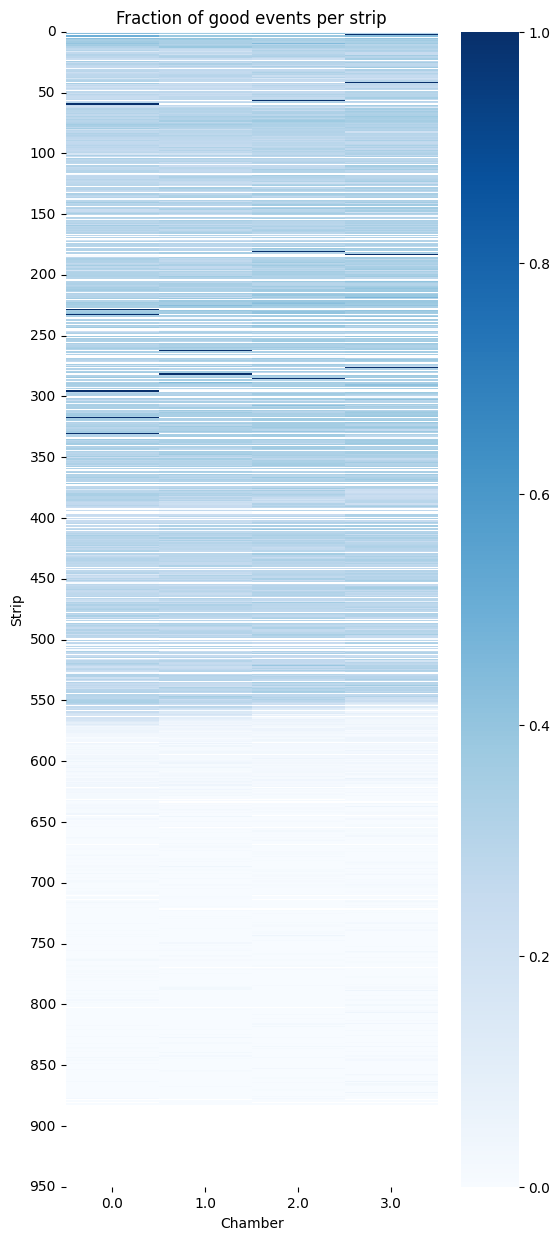

In [63]:
import seaborn as sns
def plot_good_events_vs_bad_events_per_strip_heatmap(df_processed):
    # Filter out events marked as bad
    df = df_processed
    
    # Group by chamber and calculate the fraction of good events
    grouped = df.groupby(['digiChamber_first', 'digiEta_first', 'digiStrip_mean'])['good_event'].agg(['sum', 'count'])
    grouped['fraction'] = grouped['sum'] / grouped['count']
    
    # Create a pivot table
    pivot = grouped.pivot_table(index='digiStrip_mean', columns='digiChamber_first', values='fraction')
    
    # Plot the data
    plt.figure(figsize=(6, 15))
    sns.heatmap(pivot, cmap='Blues', vmin=0, vmax=1)
    plt.title('Fraction of good events per strip')
    plt.yticks(np.arange(0,1000, 50), np.arange(0,1000, 50))
    plt.xlabel('Chamber')
    plt.ylabel('Strip')
    plt.show()
plot_good_events_vs_bad_events_per_strip_heatmap(df_processed2)